<a href="https://colab.research.google.com/github/Bertonc98/ProgettoAMD/blob/main/MarketBasketAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import json
import sys
import pandas as pd
import os
import copy
import math
import json
from collections import defaultdict
import numpy as np
import itertools as it
import time
import random
import psutil
import matplotlib.pyplot as plt
!pip install ipython-autotime
%load_ext autotime

In [3]:
!pip3 install bitmap
from bitmap import BitMap
# !pip3 install -q kaggle
# from google.colab import filesy
# print("Upload kaggle.json to use kaggle APIs")
# files.upload()
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

# !curl -OL https://raw.githubusercontent.com/Bertonc98/ProgettoAMD/main/sample.csv

# !kaggle datasets files "ashirwadsangwan/imdb-dataset"
# !kaggle datasets download "ashirwadsangwan/imdb-dataset" -f "title.principals.tsv.gz"
# !unzip "title.principals.tsv.gz.zip"
# !rm "title.principals.tsv.gz.zip"
# !gunzip -k "title.principals.tsv.gz"
# !rm "title.principals.tsv.gz"

!wget https://raw.githubusercontent.com/Bertonc98/ProgettoAMD/main/basket.zip
!unzip "basket.zip"
!rm "basket.zip"

--2021-07-16 08:58:02--  https://raw.githubusercontent.com/Bertonc98/ProgettoAMD/main/basket.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33371405 (32M) [application/zip]
Saving to: ‘basket.zip’

basket.zip          100%[===================>]  31.83M   174MB/s    in 0.2s    

2021-07-16 08:58:02 (174 MB/s) - ‘basket.zip’ saved [33371405/33371405]

Archive:  basket.zip
replace basket.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
time: 58.8 s (started: 2021-07-16 08:57:58 +00:00)


# Preprocessing


In [4]:
#PREPROCESSING to extract baskets, not run if you can dowload basket.txt
# filename = 'title.principals.tsv'
# chunksize = 50041642

# for chunk in pd.read_csv(filename, delimiter = '\t', encoding='utf-8', chunksize=chunksize, usecols=[0,2,3]):
#   actors_df = chunk[(chunk["category"] == "actor") | (chunk["category"] == "actress")]
# with open('basket.txt', 'a', encoding='UTF8') as f:
#   writer = csv.writer(f)
#   for group in actors_df[["tconst", "nconst"]].groupby(by = 'tconst'):
#     row = [int(act[2:]) for act in group[1]["nconst"]]
#     writer.writerow(row)

time: 1.93 ms (started: 2021-07-16 08:58:57 +00:00)


# Definitions

In [ ]:
#Parse the first N rows in the basket file
#Arguments: iterator pointer, int N
#Return: list parsed_basket
def create_baskets(pointer, N):
  #Create baskets parsing chunk
  basket = []
  row = next(pointer, None)
  counter = 1
  while counter < N and row != None:
    basket += [[int(x) for x in row.strip().split(',')]]
    row = next(pointer, None)
    counter += 1
  return basket

# Given a number of baskets the function extract N random baskets
# Arguments: int N
# Return: list sample
def create_sample(fraction, tot_num_rows = 3602202):
  sample = []
  counter = 0
  # Sampling
  with open("basket.txt") as f:
    for row in f:
      if random.random() < fraction:
        sample.append([int(x) for x in row.strip().split(',')])
      if len(sample) == int(fraction*tot_num_rows):
        return sample
  return sample

In [36]:
#Apriori
#Obtain the minimum index in the chunk containing the baskets
#Arguments: iterator chunk
#Return: int minimum
def get_minimum(chunk):
  mi = math.inf
  for basket in chunk:
    m = min(list(map(int, basket)))
    mi = min(m, mi)
  return mi

#Obtain the combination of the size in the baskek
#Arguments: list basket, int size
#Return: list combiantions
def get_combinations(basket, size):
    return it.combinations(sorted(basket), size)

#Update the frequency of a specific singleton, if it's not present it adds the 
#item in the position indicated by the value of the item
#Arguments: list l, int item
#Return: ---
def update_frequency(l, item):
    if item + 1 > len(l):
        l.extend((item+1-len(l))*[0])
    l[item] += 1

#Create the list of the frequency of teh singletons and return only the frequent ones
#Arguments: iterator chunk, int threshold, int m
#Return: list frequent singletons
def singleton_pairs_frequency_apriori(chunk, threshold, m):
    singleton_freq = []
    for basket in chunk:
        basket = list(map(int, basket))
        for item in basket:
            update_frequency(singleton_freq, (item-m))
    return filter_singletons(singleton_freq, m, threshold), len(singleton_freq)

#Filter the singletons, saving only the ones with a frequency over the threshold
#Arguments: list singleton, int m, int threshold
#Return: list frequent singletons
def filter_singletons(singleton, m, threshold):
    return [(iid+m,) for iid, freq in enumerate(singleton) if freq >= threshold]    

#Given tuples obtain the combinations of the size k
#Arguments: list tuples, int k
#Return: list l
def get_joins(tuples, k):
    #to obtain an element of lenght k:
    #join 2 elements of length k-1 with the first k-1 elements in common
    l = []
    for i in range(len(tuples)-1):
        for j in range(i+1, len(tuples)):
            if(tuples[i][:k-2] == tuples[j][:k-2]):
                l += [tuples[i] + tuples[j][k-2:]]
    return l

#Obtains the frequent tuples of size k, respecting the give threshold.
#The precedents frequent itemsets (of size k-1) are used to compute the combinations of size k
#Arguments: list chunk, list precedents, int threshold, int k
#Return: list frequent_itemset_size_k
def get_kth_apriori(chunk, precedents, threshold, k):
    kth = {tpl:0 for tpl in get_joins(precedents, k)}

    for basket in chunk:
        tpls = list(get_combinations(basket, k))
        for t in tpls:
          try:
            kth[t] += 1
          except:
            pass

    return [i for i in kth.keys() if kth[i] >= threshold], len(kth)

#Given a partition and a threshold comoute the frequent itemsets of increasing size
#Until get a size for which there aren't more frequent itemsets
#Arguments: iterator partition, int threshold
#Return: list frequent_itemsets
def apriori_main(partition, threshold):
      generator, chunk = it.tee(partition, 2)
      frequent_sets = []
      m = get_minimum(chunk)
      #Re-generate the iterator
      chunk = copy.copy(generator)

      result, n_comb = singleton_pairs_frequency_apriori(chunk, threshold, m)
      frequent_sets += result
      precedents = result
      n_combinations = [n_comb]

      k = 2
      while result != []:
          # Update the memory usage 

          chunk = copy.copy(generator)
          result, n_comb_k = get_kth_apriori(chunk, precedents, threshold, k)
          n_combinations.append(n_comb_k)
          
          frequent_sets = frequent_sets + result
          precedents = result
          k += 1

      return frequent_sets, n_combinations

#Given the dictionary of candidates update the frequency of the item
#Arguments: dict candidates_dict, int el
#Return: ---
def dict_update(candidates_dict, el):
  try:
    candidates_dict[el] += 1
  except:
    pass

#Given the threshold for a single chunk, the number of chunks and their size
#compute the frequent itemsets using the apriori algorithm
#Arguments: int t, int N, int n_chunk
#Return: list frequent_itemsets
def apriori_SON(t, N, n_chunk, experiment = 0):
  result_apriori = []
  n_combinations = []
  son_times = []
  with open("basket.txt") as f:
    for i in range(n_chunk):
      #print(f"Elaborating chunk {i}")

      basket = create_baskets(f, N)
      
      son_start_time = time.time()
      #Applying Apriori
      chunk_candidates, n_comb_partition = apriori_main(iter(basket), t)
      result_apriori += chunk_candidates

      #Update combinations lists to match the maximum size of frequent itemsets found

      if experiment == 0:
        n_combinations.append(n_comb_partition[1:])
      elif experiment == 1:
        n_combinations.append(sum(n_comb_partition[1:]))
      else:
        print("experiment value out of range [0,1]")
        exit(0)
      son_times += [time.time()-son_start_time]
      
  result_apriori = {k:0 for k in set(result_apriori)}

  counter = 0
  #Check
  son_start_time = time.time()
  with open("basket.txt") as f:
    for row in f:
      basket = [int(x) for x in row.strip().split(',')]

      for size in range(1, len(basket)+1):
        for el in get_combinations(basket, size):
          dict_update(result_apriori, el)
      counter += 1
      if counter > N*n_chunk:
        break
  filtered_baskets = [el for el,v in result_apriori.items() if v >= (t*n_chunk)]
  son_times += [time.time()-son_start_time]
  return filtered_baskets, n_combinations, son_times

time: 292 ms (started: 2021-07-16 09:35:33 +00:00)


In [40]:
#PCY
#Return the hashed element mod the size of the hashmap
#Arguments: int element, int size
#Return: int hashed_value
def hashF(element, size):
    return hash(element)%size

#Create the list of the frequency of the singletons and return only the frequent ones
#Meanwhile it creates the hashmap of the couple of items
#Arguments: iterator chunk, int hash_size, int threshold, int m
#Return: list frequent singletons, list hashmap
def singleton_pairs_frequency_pcy(chunk, hash_size, threshold, m):
    singleton_freq = []
    hashmap = np.zeros(hash_size)
    for basket in chunk:
        basket = list(map(int, basket))
        for item in basket:
            update_frequency(singleton_freq, item-m)
        for pair in get_combinations(basket, 2):
            hashmap[hashF(pair, hash_size)] += 1
    return filter_singletons(singleton_freq, m, threshold), hashmap, len(singleton_freq)

# this function collapse the hashmap given in input into a bitmap of size "size" 
# and set a 1 in the bitmap if the value in
# the hashmap is over the the given threshold
# Arguments: list hashmap, int size, int threshold
# Return: bitmap bmap
def hash_to_bitmap(hashmap, size, threshold):
    bmap = BitMap(size)
    for position in range(len(hashmap)):
        if hashmap[position] >= threshold:
            bmap.set(position)
    del hashmap
    return bmap

# Obtains the frequent tuples of size k, respecting the give threshold.
# The precedents frequent itemsets (of size k-1) are used to compute the combinations of size k
# The bmap is used to filter nonfrequent itemsets of size k-1
# Meanwhile it computes the hashmap for itemsets od size k+1
# Arguments: list chunk, list precedents, int hash_size, int threshold, int k
# Return: list frequent_itemset_size_k, list next_hashmap
def get_kth(chunk, precedents, hash_size, bmap, threshold, k):
    kth = {tpl:0 for tpl in get_joins(precedents, k) if bmap[hashF(tpl, hash_size)]}
    next_hashmap = np.zeros(hash_size)
    
    for basket in chunk:
        # basket = list(map(int, basket))
        tpls = list(get_combinations(basket, k))
        for t in tpls:
          try:
            kth[t] += 1
          except:
            pass
        for kth_tuples in get_combinations(basket, k+1):
            next_hashmap[hashF(kth_tuples, hash_size)] += 1

    return [k for k,v in kth.items() if v >= threshold], next_hashmap, len(kth)

#Given a partition and a threshold comoute the frequent itemsets of increseing size
#Until get a size for which there aren't more frequent itemsets
#Arguments: iterator partition, int threshold, int hash_size
#Return: list frequent_itemsets
def pcy_main(partition, threshold, hash_size):
      #Create a copy of the iterator and initialize structures
      generator, chunk = it.tee(partition, 2)
      frequent_sets = []
      m = get_minimum(chunk)
      chunk = copy.copy(generator)

      result, hashmap, n_comb = singleton_pairs_frequency_pcy(chunk, hash_size, threshold, m)
      bitmap = hash_to_bitmap(hashmap, hash_size, threshold)
      
      del hashmap
      #Update frequent_sets with the singletons
      frequent_sets += result
      precedents = result
      n_combinations = [n_comb]

      k = 2
      result = ["placeholder"]
      while result != []:
          chunk = copy.copy(generator)
          result, hashmap, n_comb = get_kth(chunk, precedents, hash_size, bitmap, threshold, k)
          bitmap = hash_to_bitmap(hashmap, hash_size, threshold)

          del hashmap
          n_combinations.append(n_comb)
          frequent_sets += result
          precedents = result
          k += 1
          
      return frequent_sets, n_combinations

# Given the threshold for a single chunk, the number of chunks and their size
# compute the frequent itemsets using the apriori algorithm, exploting a bitmap
# in order to filter mote itemsets
# Arguments: int t, int N, int n_chunk, int hash_size
# Return: list frequent_itemsets
def PCY_SON(t, N, n_chunk, hash_size, experiment = 0):
  result_pcy = []
  n_combinations = []
  son_times = []
  with open("basket.txt") as f:
    for i in range(n_chunk):
      # print(f"Elaborating chunk {i}")

      #Create baskets parsing chunk
      basket = create_baskets(f, N)

      son_start_time = time.time()
      #Applying PCY
      chunk_candidates, n_comb_partition= pcy_main(iter(basket), t, hash_size)
      result_pcy += chunk_candidates

      #Update combinations lists to match the maximum size of frequent itemsets found
      if experiment == 0:
        n_combinations.append(n_comb_partition[1:])
      elif experiment == 1:
        n_combinations.append(sum(n_comb_partition[1:]))
      else:
        print("experiment value out of range [0,1]")
        exit(0)
      son_times += [time.time()-son_start_time]

  result_pcy = {k:0 for k in set(result_pcy)}  

  counter = 0
  #Check
  son_start_time = time.time()
  with open("basket.txt") as f:
    for row in f:
      basket = [int(x) for x in row.strip().split(',')]

      for size in range(1, len(basket)+1):
        for el in get_combinations(basket, size):
          dict_update(result_pcy, el)
      counter += 1
      if counter > N*n_chunk:
        break
  son_times += [time.time()-son_start_time]
  return [el for el,v in result_pcy.items() if v >= (t*n_chunk)], n_combinations, son_times

time: 205 ms (started: 2021-07-16 09:40:22 +00:00)


In [41]:
# TOIVONEN
# Take a sample of the total, a fraction p€[0,1] (adjust the threshold s = p * s)
# Run Apriori over it and obtain the candidates frequent itemset from the sample
# Build the negative border from candidates
# Scan all the basket and check for itemset in candidates or in negative border:
#   - If no element from the negative border is frequent return candidates as frequent itemsets
#   - Otherwise no answer, need to rerun with different sample or threshold

# Turn the apriori over the sample
# Arguments: int t, list sample
# Return: list chunk_candidates
def APRIORI_TOIVONEN(t, sample):
  #Applying a priori algorithm
  chunk_candidates, _ = apriori_main(iter(sample), t)
  return chunk_candidates

# Given the sample and the candidates it computes the negative border
# Arguments: list candidates, list sample
# Return: list negative_border
def negative_border(candidates, sample):
  #find all the singleton that must be in NB = all non frequent singletons
  diff = []
  for row in sample:
    for el in row:
      try:
        candidates[(el,)]
      except:
        diff += [(el,)]

  nb = diff
  prev_freq = [el for el, _  in candidates.items() if len(el) == 1]
  k=2
  #for each k find all the itemset of lenght k composed by frequent sets of length k-1 that are not frequent.
  # max(map(len, c))+1 take the maximum length in frequent set. The cycle must find all sets in the NB till this length + 1
  while k<= max(map(len, candidates.items()))+1:
    
    diff = []
    # Get every composition of size k, from candidates frequent elements of size k-1
    for kth in get_joins(prev_freq, k):
      try:
        candidates[kth]
      except:
        diff += [kth]

    nb += diff
    prev_freq = [el for el, _ in candidates.items() if len(el) == k]
    k += 1
  return nb

# Updates the negative border dictionary or the candidates dictionary for each 
# combiantions in the baskets
# Arguments: list baskets
# Return: ---
def candidates_nb_update(basket):
  l = len(basket)
  b = sorted(basket)
  lista = []
  for i in range(1, l+1):
    for el in it.combinations(b, i):
      try:
        nb[el] += 1
      except:
        pass
      try:
        c_dict[el] += 1
      except:
        pass

time: 44 ms (started: 2021-07-16 09:41:26 +00:00)


# CANDIDATES SIZES

In [ ]:
#Apriori
t = 2000
N = 600367
n_chunks = 6
tot = N * n_chunks
with open("basket.txt") as f:
  baskets = create_baskets(f, tot)

time: 9.96 s (started: 2021-07-15 19:39:38 +00:00)


In [ ]:
apriori_times = []
start_time = time.time()
res, apriori_sizes = apriori_main(iter(baskets), t)
print(apriori_sizes)

In [ ]:
#PCY
hash_size = 2**20
pcy_memory = []
pcy_times = []

start_time = time.time()
res, pcy_sizes = pcy_main(iter(baskets), t, hash_size)
print(sys.getsizeof(res), "bytes")
print(pcy_sizes)

In [ ]:
#apriori SON
t = 2000//6
N = 600367
n_chunk = 6

result, son_apriori_sizes, _ = apriori_SON(t, N, n_chunk, 0)

print(son_apriori_sizes)

In [ ]:
#PCY SON
hash_size = 2**18
result_pcy, son_pcy_sizes, _ = PCY_SON(t, N, n_chunk, hash_size, 0)
print(son_pcy_sizes)

[[36, 12, 1, 0], [2010, 574, 187, 32, 3, 0], [337, 164, 83, 23, 3, 0], [315, 257, 233, 170, 94, 37, 9, 1, 0], [414, 214, 199, 156, 92, 37, 9, 1, 0], [3768, 645, 464, 309, 166, 59, 12, 1, 0]]
time: 9min 44s (started: 2021-07-15 10:04:27 +00:00)


In [ ]:
sps = [[36, 12, 1, 0], [2010, 574, 187, 32, 3, 0], [337, 164, 83, 23, 3, 0], [315, 257, 233, 170, 94, 37, 9, 1, 0], [414, 214, 199, 156, 92, 37, 9, 1, 0], [3768, 645, 464, 309, 166, 59, 12, 1, 0]]
lsp = [0]*max(map(len,sps))
for el in range(len(lsp)):
  lsp[el] = sum([l[el] for l in sps if len(l) > el])
lsp

[6880, 1866, 1167, 690, 358, 133, 30, 3, 0]

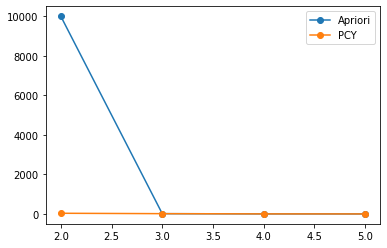

time: 163 ms (started: 2021-07-10 09:55:34 +00:00)


In [ ]:
x = list(range(2, len(apriori_sizes)+1))
plt.plot(x, apriori_sizes[1:], "-o")
plt.plot(x, pcy_sizes[1:], "-o")

# x = list(range(3, len(son_apriori_sizes)+1))
# plt.plot(x, son_apriori_sizes[2:], "-o")
# plt.plot(x, son_pcy_sizes[2:], "-^")
plt.legend(["Apriori", "PCY", "SON-apriori", "SON-PCY"])
plt.show()

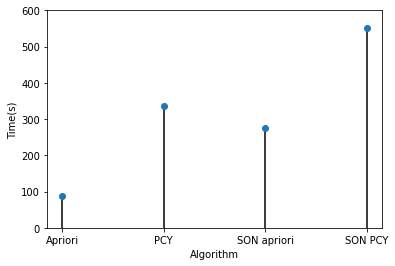

time: 191 ms (started: 2021-07-13 19:57:37 +00:00)


In [ ]:
timing = [87, 335, 275, 551]
plt.plot(["Apriori", "PCY", "SON apriori", "SON PCY"], timing, "o")
plt.vlines(["Apriori", "PCY", "SON apriori", "SON PCY"], [0]*4, timing)
plt.ylim(0, 600)
plt.xlabel("Algorithm")
plt.ylabel("Time(s)")
plt.show()

# Time chanching threshold

In [ ]:
N = 600000
t = range(150, 500, 50)
with open("basket.txt") as f:
  baskets = create_baskets(f, N)

time: 2.1 s (started: 2021-07-14 07:39:11 +00:00)


In [ ]:
apriori_times = []
for threshold in t:
  start_time = time.time()
  res, _ = apriori_main(iter(baskets), threshold)
  apriori_times += [time.time() - start_time]

time: 2min 12s (started: 2021-07-14 08:17:24 +00:00)


In [ ]:
pcy_times = []
for threshold in t:
  start_time = time.time()
  res, _ = pcy_main(iter(baskets), threshold, 2**18)
  pcy_times += [time.time() - start_time]

time: 7min 43s (started: 2021-07-14 07:42:08 +00:00)


In [ ]:
n_chunk = 10
# contains worse chunk's execution time
son_apriori_times = []
for threshold in t:
  print(f"computing with t = {threshold}")
  result, _, tmp_apriori_son_times = apriori_SON(threshold/n_chunk, N/n_chunk, n_chunk)
  son_apriori_times.append(max(tmp_apriori_son_times[:n_chunk]) + tmp_apriori_son_times[n_chunk])

computing with t = 150
computing with t = 200
computing with t = 250
computing with t = 300
computing with t = 350
computing with t = 400
computing with t = 450
time: 10min 31s (started: 2021-07-14 07:49:51 +00:00)


In [ ]:
n_chunk = 10
# contains worse chunk's execution time
son_pcy_times = []
for threshold in t:
  print(f"computing with t = {threshold}")
  result, _, tmp_pcy_son_times = PCY_SON(threshold/n_chunk, N/n_chunk, n_chunk, 2**18)
  son_pcy_times.append(max(tmp_pcy_son_times[:n_chunk]) + tmp_pcy_son_times[n_chunk])

computing with t = 150
computing with t = 200
computing with t = 250
computing with t = 300
computing with t = 350
computing with t = 400
computing with t = 450
time: 16min 34s (started: 2021-07-14 08:00:22 +00:00)


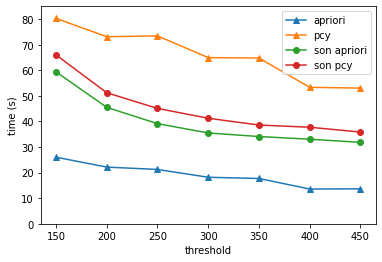

time: 240 ms (started: 2021-07-14 08:19:37 +00:00)


In [ ]:
plt.plot(list(t),apriori_times, "-^")
plt.plot(list(t),pcy_times, "-^")
plt.plot(list(t),son_apriori_times, "-o")
plt.plot(list(t),son_pcy_times, "-o")
plt.legend(["apriori", "pcy", "son apriori", "son pcy"])
plt.xlabel("threshold")
plt.ylabel("time (s)")
plt.ylim(0, 85)
plt.show()

In [ ]:
for ts in range(len(t)):
  print(t[ts],round(apriori_times[ts],2), round(pcy_times[ts], 2), round(son_apriori_times[ts], 2), round(son_pcy_times[ts], 2), sep=" & ") 

150 & 26.04 & 80.3 & 59.4 & 66.0
200 & 22.17 & 73.13 & 45.51 & 51.23
250 & 21.24 & 73.46 & 39.15 & 45.1
300 & 18.19 & 64.96 & 35.51 & 41.26
350 & 17.72 & 64.81 & 34.12 & 38.6
400 & 13.59 & 53.35 & 33.07 & 37.75
450 & 13.67 & 53.04 & 31.83 & 35.86
time: 5.33 ms (started: 2021-07-14 08:22:51 +00:00)


# Candidates number and timing with different hash size

In [ ]:
N = 600000
t = 350
with open("basket.txt") as f:
  baskets = create_baskets(f, N)
h = [2**x for x in range(12, 21)]

time: 1.89 s (started: 2021-07-13 20:05:43 +00:00)


In [ ]:
pcy_times = []
pcy_sizes = []
for h_size in h:
  start_time = time.time()
  res, candidates = pcy_main(iter(baskets), t, h_size)
  pcy_times += [time.time() - start_time]
  pcy_sizes.append(candidates)

time: 8min 18s (started: 2021-07-13 20:39:00 +00:00)


[]

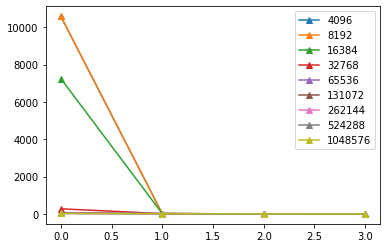

time: 241 ms (started: 2021-07-13 20:19:23 +00:00)


In [ ]:
for el in pcy_sizes:
  plt.plot(list(range(len(el)-1)), el[1:], "-^")
plt.legend(h)
plt.plot()

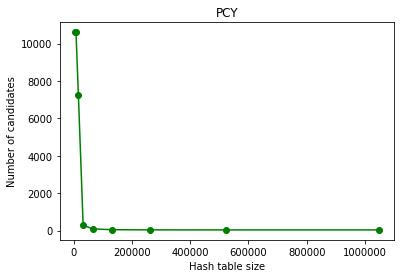

time: 311 ms (started: 2021-07-13 20:28:01 +00:00)


In [ ]:
sizes = [sum(el[1:]) for el in pcy_sizes]
plt.plot(h, sizes, "g-o")
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel("Hash table size")
plt.ylabel("Number of candidates")
plt.title("PCY")
plt.show()

In [ ]:
print(sizes)
print(h)

[10603, 10603, 7266, 292, 93, 50, 40, 38, 38]
[4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576]
time: 17 ms (started: 2021-07-13 20:28:47 +00:00)


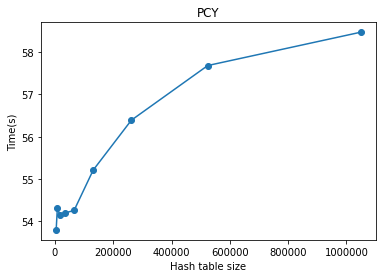

time: 322 ms (started: 2021-07-13 21:14:53 +00:00)


In [ ]:
plt.plot(h, pcy_times, "-o")
plt.xlabel("Hash table size")
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel("Time(s)")
plt.title("PCY")
plt.show()

In [ ]:
x=[[1298466, 2708, 1885, 1132, 490, 141, 18, 0],
 [1184986, 2708, 1885, 1132, 490, 138, 16, 0],
 [426376, 2610, 1872, 1116, 472, 126, 16, 0],
 [136309, 2251, 1656, 990, 432, 122, 16, 0],
 [54448, 2019, 1472, 886, 399, 116, 16, 0],
 [25377, 1940, 1353, 811, 378, 111, 13, 0],
 [3604, 782, 301, 66, 8, 0],
 [2301, 771, 294, 64, 8, 0],
 [1671, 754, 284, 59, 7, 0]]
[sum(y) for y in x]

[1304840, 1191355, 432588, 141776, 59356, 29983, 4761, 3438, 2775]

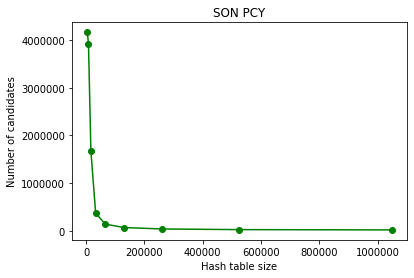

time: 278 ms (started: 2021-07-13 21:19:03 +00:00)


In [ ]:
sizes = [sum(el[1:]) for el in son_pcy_candidates]
plt.plot(h, sizes, "g-o")
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel("Hash table size")
plt.ylabel("Number of candidates")
plt.title("SON PCY")
plt.show()

# TOIVONEN execution

In [ ]:
t = 333 #taking 1/6 of the total size
#Chunk size in rows
N = 600367

sample = create_sample(1/6)
c_dict = dict.fromkeys(APRIORI_TOIVONEN(t, sample), 0)
nb = dict.fromkeys(negative_border(c_dict, sample), 0)
with open(txt) as f:
  counter = 0
  basket = next(f, None)
  while basket != None:
    basket = [int(x) for x in basket.strip().split(',')]
    candidates_nb_update(basket)
    basket = next(f, None)

t2 = 2000 #Total threshold over the whole dataset
buleano = True
for frequency in nb.values():
  if (frequency >= t2):
    buleano = False
    break
if (buleano):
  c_dict = {k:v for k,v in c_dict.items() if v >= t2}
  print("V")
else:
  print("E")

# Negative border size cahnging threshold

In [ ]:
thresholds = [x for x in range(1500, 4000, 500)]
N = 600367
sample = create_sample(N)
toivonen_nb_sizes = []
toivonen_nb_times = []
for t in thresholds:
  c_dict = dict.fromkeys(APRIORI_TOIVONEN(t//6, sample), 0)
  start_time = time.time()
  nb = dict.fromkeys(negative_border(c_dict, sample), 0)
  toivonen_nb_times.append(time.time()-start_time)
  toivonen_nb_sizes.append(len(nb))
  with open(txt) as f:
    counter = 0
    basket = next(f, None)
    while basket != None:
      basket = [int(x) for x in basket.strip().split(',')]
      candidates_nb_update(basket)
      basket = next(f, None)

  buleano = True
  for frequency in nb.values():
    if (frequency >= t):
      buleano = False
      break
  if (buleano):
    c_dict = {k:v for k,v in c_dict.items() if v >= t}
    print("Frequent candidates found")
  else:
    print("No answer")

No answer
No answer
No answer
No answer
No answer
time: 22min 33s (started: 2021-07-15 09:34:10 +00:00)


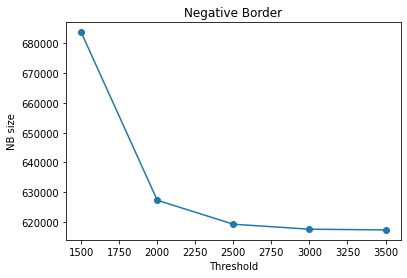

time: 219 ms (started: 2021-07-15 09:58:42 +00:00)


In [ ]:
plt.plot(thresholds, toivonen_nb_sizes, "-o")
plt.title("Negative Border")
plt.ylabel("NB size")
plt.xlabel("Threshold")
plt.show()

In [ ]:
t = 2000
fractions = list(map(lambda x: 1/x,range(6, 13)))

for fract in fractions:
  sample = create_sample(fract)
  c_dict = dict.fromkeys(APRIORI_TOIVONEN(int(t*fract), sample), 0)
  
  nb = dict.fromkeys(negative_border(c_dict, sample), 0)

  with open(txt) as f:
    counter = 0
    basket = next(f, None)
    while basket != None:
      basket = [int(x) for x in basket.strip().split(',')]
      candidates_nb_update(basket)
      basket = next(f, None)

  #questions about the name? Ask to Alberto.
  buleano = True
  for frequency in nb.values():
    if (frequency >= t):
      buleano = False
      break
  if (buleano):
    c_dict = {k:v for k,v in c_dict.items() if v >= t}
    print(f"Frequent candidates found with fraction {fract}")
  else:
    print(f"No answer with fraction {fract}")

Frequent candidates found with fraction 0.16666666666666666
